# Differential Analysis Result Tables 

- [ ] short report about raw data and experiment design 
- [ ] describe analysis workflow and applied tools 
- [ ] describe results (plots, tables)
- [ ] final interpretation 

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

from matplotlib import style 
# style.use('seaborn-colorblind')
sns.set(style='white')

#adapted from http://nbviewer.ipython.org/github/cs109/content/blob/master/lec_03_statistical_graphs.ipynb    
# https://sourcegraph.com/github.com/mhorlbeck/ScreenProcessing@4d8298df6ab831fd1bd160235488f3450f57363e/-/blob/screen_analysis.py?L570:5
def cleanAxes(axis, top=False, right=False, bottom=True, left=True):
    axis.spines['top'].set_visible(top)
    axis.spines['right'].set_visible(right)
    axis.spines['left'].set_visible(left)
    axis.spines['bottom'].set_visible(bottom)

    #turn off all ticks
    axis.yaxis.set_ticks_position('none')
    axis.xaxis.set_ticks_position('none')

    #now re-enable visibles
    if top:
        axis.xaxis.tick_top()
    if bottom:
        axis.xaxis.tick_bottom()
    if left:
        axis.yaxis.tick_left()
    if right:
        axis.yaxis.tick_right()


## CRISPRi-screen
Aim: analyzing differential phenotype of CRISPRi-screen data

Tool: [ScreenProcessing](https://github.com/mhorlbeck/ScreenProcessing)

#### Result:
`CRISPRi-screen/hl60_exp1/DAC_processing_output_genetable_collapsed.txt`
<!--`CRISPRi-screen/hl60_exp2/DAC_processing_output_genetable_collapsed.txt`-->

In [556]:
Ci_counts

,T0,T0.1,treated,treated.1,untreated,untreated.1
gene,,,,,,
A1BG,348,348,46,175,275,149
A1BG,584,584,327,358,816,594
A1BG,689,689,392,751,568,442
A1BG,368,368,1180,266,432,370
A1BG,596,596,110,403,365,369
...,...,...,...,...,...,...
ZZZ3,1596,1596,921,1197,1393,1080
ZZZ3,882,882,473,409,913,729
ZZZ3,2118,2118,1013,1287,1656,1147


In [484]:
Ci_counts = pd.read_csv('CRISPRi-screen/hl60_exp1/DAC_mergedcountstable.txt',sep='\t').set_index('Unnamed: 0').iloc[2:,:]
Ci_counts['gene'] = Ci_counts.index.str.split('_').str[0]
Ci_counts = Ci_counts[Ci_counts.gene != 'non-targeting'].set_index('gene')

In [537]:
def plot_Ci_counts(counts,gene,ax=None,plot='boxplot',T0=False):
    
    # df = counts[counts.gene == gene].drop('gene',axis=1).T
    df = counts[counts.index == gene].T
    df['treatment'] = ["T0","T0","Decitabine","Decitabine","DMSO","DMSO"]
    
    # df_column_uniquify
    df_columns = df.columns
    new_columns = []
    for counter,item in enumerate(df_columns):
        if gene in item:
            newitem = "{}_gRNA{}".format(item, counter + 1)
        else:
            newitem = item
        new_columns.append(newitem)
    df.columns = new_columns
    
    dd=pd.melt(
        df,
        id_vars='treatment',value_vars=[col for col in df.columns if gene in col],var_name='columns'
    )
    data_title = "gRNA count" # Normalized
    dd = dd.rename({'value':data_title},axis=1)
    dd[data_title] = dd[data_title].astype(int)
    my_pal = {"Decitabine": "c", "DMSO": "lightgray", 'T0':'azure'}
    
    if not T0:
        dd = dd[dd.treatment != 'T0'].sort_values(by='treatment', axis=0, ascending=True)
    if ax:
        cleanAxes(ax)
        if plot == 'pointplot':
            p = sns.pointplot(x='treatment',y=data_title,data=dd,hue='treatment',palette=my_pal,ax=ax).set(title=gene)
        if plot == 'boxplot':
            p = sns.boxplot(x='treatment',y=data_title,data=dd,hue='treatment',palette=my_pal,ax=ax).set(title=gene)
        return p
    else: 
        return dd

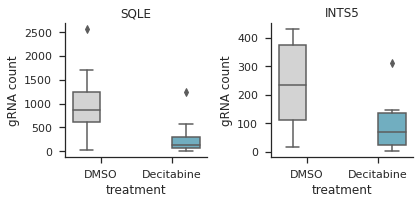

In [555]:
f, axes = plt.subplots(1, 2,figsize=(6,3))

plot_Ci_counts(Ci_counts,gene = 'SQLE',ax=axes[0])
axes[0].legend('')
plot_Ci_counts(Ci_counts,gene = 'INTS5',ax=axes[1])
axes[1].legend('')
# axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()

> __Note__: all 5 gRNAs considered here. 

## RNA-seq
Aim-1: analyzing differential experssion of RNA-seq data

Tool: [DESeq2](https://bioconductor.org/packages/release/bioc/html/DESeq2.html), [iPAGE](https://github.com/goodarzilab/PAGE)

#### Result: 
`RNA-seq/hl60-exp/hl60_exp_deseq2_norm.txt` - normalized counts 

`RNA-seq/hl60-exp/hl60_delta_exp_table.txt`
- `gene_id`
- `gene_name`
- `baseMean`
- `log2FC_6h`
- `pval_6h`
- `log2FC_72h`
- `pval_72h`
- `log2FC_120h`
- `pval_120h`

Aim-2: cell line consistency analysis 


In [382]:
# exp = pd.read_csv('RNA-seq/exp/delta_exp_table.txt',sep='\t')

### Expression

In [383]:
exp_counts  = pd.read_csv('RNA-seq/exp/deseq2_norm.txt',sep='\t')

In [384]:
def plot_time_rna_seq(counts,gene,ax,data,plot='boxplot'):
    
    df = counts[counts['name'] == gene].set_index('name').T
    df['treatment'] = df.index.str.split('_').str[-2]
    df['line'] = df.index.str.split('_').str[0]
    df['time'] = 72
    df.loc[df.line == 'hl60','time'] = df[df.line == 'hl60'].index.str.split('_').str[1].str[:-1].astype(int)

    dd=pd.melt(
        df[df.line == 'hl60'],
        id_vars=['treatment','time'],value_vars=[gene],var_name='columns'
    ).sort_values(by='time', axis=0, ascending=True)
    dd['treatment'] = dd['treatment'].str.replace('t', 'Decitabine')
    dd['treatment'] = dd['treatment'].str.replace('u', 'DMSO')
    dd = dd.sort_values(by='treatment', axis=0, ascending=True).rename({'value':f'Normalized {data}'},axis=1)
    my_pal = {"Decitabine": "c", "DMSO": "lightgray"}
    
    cleanAxes(ax)
    if plot == 'pointplot':
        p = sns.pointplot(x='time',y=f'Normalized {data}',data=dd,hue='treatment',palette=my_pal,ax=ax).set(title=gene)
    if plot == 'boxplot':
        p = sns.boxplot(x='time',y=f'Normalized {data}',data=dd,hue='treatment',palette=my_pal,ax=ax).set(title=gene)
    return p

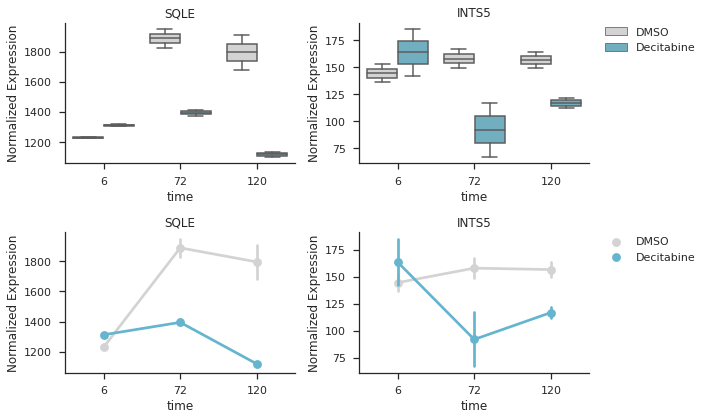

In [560]:
f, axes = plt.subplots(2, 2,figsize=(10,6))

plot_time_rna_seq(exp_counts,gene = 'SQLE',ax=axes[0,0],data='Expression')
axes[0,0].legend('')
plot_time_rna_seq(exp_counts,gene = 'INTS5',ax=axes[0,1],data='Expression')
axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plot_time_rna_seq(exp_counts,gene = 'SQLE',ax=axes[1,0],data='Expression',plot='pointplot')
axes[1,0].legend('')

plot_time_rna_seq(exp_counts,gene = 'INTS5',ax=axes[1,1],data='Expression',plot='pointplot')
axes[1,1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()

## Stability

In [ ]:
stbl_counts = pd.read_csv('RNA-seq/stbl/normalized_stbl_count_table.txt',sep='\t')

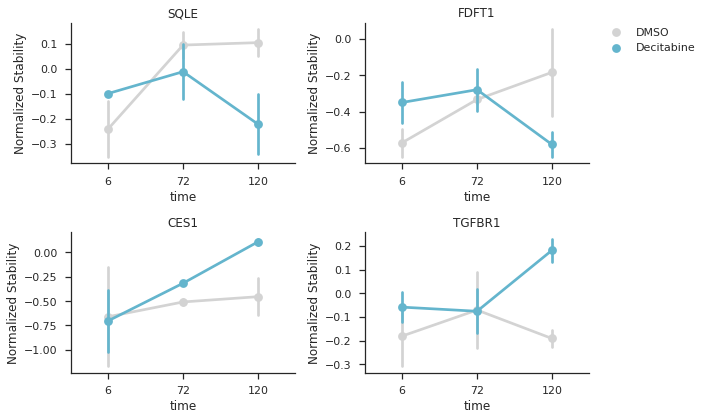

In [558]:
f, axes = plt.subplots(2, 2,figsize=(10,6))

plot_time_rna_seq(stbl_counts,gene = 'SQLE',ax=axes[0,0],data='Stability',plot='pointplot')
axes[0,0].legend('')
plot_time_rna_seq(stbl_counts,gene = 'FDFT1',ax=axes[0,1],data='Stability',plot='pointplot')
axes[0,1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plot_time_rna_seq(stbl_counts,gene = 'CES1',ax=axes[1,0],data='Stability',plot='pointplot')
axes[1,0].legend('')
plot_time_rna_seq(stbl_counts,gene = 'TGFBR1',ax=axes[1,1],data='Stability',plot='pointplot')
axes[1,1].legend('')

plt.tight_layout()

> #### FDFT1
> [__Azacitidine in combination with chemotherapy in pediatric AML patients– a phase I study__](https://aml-hub.com/medical-information/azacitidine-in-combination-with-chemotherapy-in-pediatric-aml-patients-a-phase-i-study)
> - _FDFT1 was significantly different between responders and non-responders, P = 0.002_

## meRIP-seq
Experiment design: Two replicates of samples for both treated with Decitabine drug and non-treated (
`T1.input.bam`
`T1.m6A.bam`
`T2.input.bam`
`T2.m6A.bam`
`U1.input.bam`
`U1.m6A.bam`
`U2.input.bam`
`U2.m6A.bam`
) used for meRIP-seq experiment. 

Aim: analyzing differential methylation of MeRIP-seq data

Tool: [RADAR](https://github.com/scottzijiezhang/RADAR)

#### Result: 
`meRIP-seq/hl60_delta_mtyl_table.txt`. 
_Columns_: 
- `chr`
- `start`
- `end`
- `name`
- `score`
- `strand`
- `thickStart`
- `thickEnd`
- `itemRgb`
- `blockCount`
- `blockSizes`
- `blockStarts`
- `logFC`
- `p_value`
- `ensembl`

## Ribo-seq

Aim: analyzing differential translation of Ribo-seq data

Tool: [Ribolog](https://github.com/goodarzilab/Ribolog)


#### Result:
`Ribo-seq/hl60_delta_te_table.txt`

- `transcript`
- `gene_id`
- `gene_name`
- `Estimate_treatmentDRUG`
- `Pr...z.._treatmentDRUG`
- `fdr_Pr...z.._treatmentDRUG`
- `qvalue_Pr...z.._treatmentDRUG`


# Combined Analysis

- [ ] describe analysis purpose 
- [ ] describe results (plots, tables)
- [ ] final interpretation 

## hyper-geometric-test

## mtyl-enrichment

## intersectional-genes
